In [2]:
!pip install --quiet pandas numpy scikit-learn matplotlib seaborn torch torchvision tqdm joblib
!pip install --quiet d3rlpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 721.7/721.7 kB 14.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 201.1/201.1 kB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 958.1/958.1 kB 34.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.5/72.5 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 2.6 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dopamine-rl 4.1.2 requires gym<=0.25.2, but you have gym 0.26.2 which is incompatible.


In [3]:
import os
import gc
import time
import math
import joblib
import zipfile
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score, confusion_matrix, roc_curve, auc
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset

# reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)


In [4]:
ACCEPTED_CSV = "accepted_2007_to_2018Q4.csv.gz"
REJECTED_CSV = "rejected_2007_to_2018Q4.csv.gz"
os.makedirs("data/processed", exist_ok=True)
os.makedirs("models", exist_ok=True)

# quick check
print("Files present:", [f for f in os.listdir(".") if f.endswith(".gz")])


Files present: ['rejected_2007_to_2018Q4.csv.gz', 'accepted_2007_to_2018Q4.csv.gz']


In [5]:
# Change sample_frac to small value for quick experiments, then larger (e.g., 0.2) for final training.
SAMPLE_FRAC = 0.02   # 2% sample for quick iteration
CHUNK_SIZE = 200_000  # adjust to available RAM

def sample_accepted_csv(infile=ACCEPTED_CSV, outfile="data/processed/accepted_sample.csv.gz", frac=SAMPLE_FRAC, seed=RANDOM_SEED):
    if os.path.exists(outfile):
        print("Sample already exists:", outfile)
        return outfile
    print("Sampling accepted dataset (frac=", frac, ") ...", sep="")
    reader = pd.read_csv(infile, compression='gzip', low_memory=False, iterator=True, chunksize=CHUNK_SIZE)
    sampled_chunks = []
    for chunk in tqdm(reader, desc="Chunks"):
        sampled_chunks.append(chunk.sample(frac=frac, random_state=seed))
    sample_df = pd.concat(sampled_chunks, ignore_index=True)
    sample_df.to_csv(outfile, index=False, compression='gzip')
    print("Saved sample to", outfile, "with shape", sample_df.shape)
    return outfile

sample_file = sample_accepted_csv()


Sampling accepted dataset (frac=0.02) ...


Chunks: 12it [01:35,  7.97s/it]


Saved sample to data/processed/accepted_sample.csv.gz with shape (45214, 151)


Shape (sample): (45214, 151)
Columns (example): ['id', 'member_id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'term', 'int_rate', 'installment', 'grade', 'sub_grade', 'emp_title', 'emp_length', 'home_ownership', 'annual_inc', 'verification_status', 'issue_d', 'loan_status', 'pymnt_plan', 'url', 'desc', 'purpose', 'title', 'zip_code', 'addr_state', 'dti', 'delinq_2yrs', 'earliest_cr_line', 'fico_range_low', 'fico_range_high', 'inq_last_6mths']
loan_status
Fully Paid                                             21583
Current                                                17543
Charged Off                                             5285
Late (31-120 days)                                       439
In Grace Period                                          209
Late (16-30 days)                                         91
Does not meet the credit policy. Status:Fully Paid        49
Does not meet the credit policy. Status:Charged Off       13
Default                                         

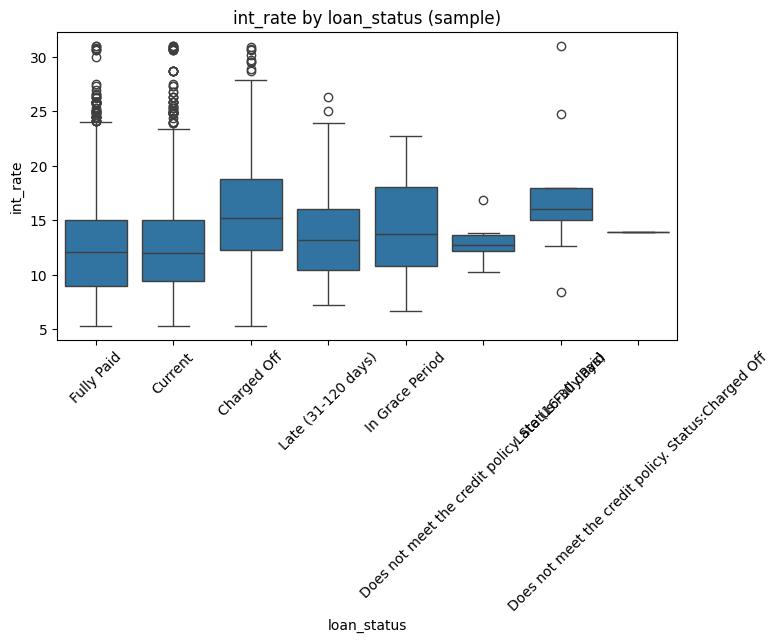

member_id                                     1.000000
orig_projected_additional_accrued_interest    0.996152
hardship_reason                               0.995466
hardship_payoff_balance_amount                0.995466
hardship_last_payment_amount                  0.995466
payment_plan_start_date                       0.995466
hardship_type                                 0.995466
hardship_status                               0.995466
hardship_start_date                           0.995466
deferral_term                                 0.995466
hardship_amount                               0.995466
hardship_dpd                                  0.995466
hardship_loan_status                          0.995466
hardship_length                               0.995466
hardship_end_date                             0.995466
settlement_status                             0.985093
debt_settlement_flag_date                     0.985093
settlement_term                               0.985093
settlement

In [6]:
df = pd.read_csv(sample_file, compression='gzip', low_memory=False)
print("Shape (sample):", df.shape)
print("Columns (example):", df.columns[:30].tolist())

# Show loan_status counts
print(df['loan_status'].value_counts().head(20))

# Basic numeric distributions
print(df[['loan_amnt','int_rate','annual_inc','dti','installment']].describe().T)

# Convert int_rate string to float if needed
if df['int_rate'].dtype == object:
    df['int_rate'] = df['int_rate'].str.rstrip('%').astype(float)

# Plot loan_status vs int_rate
plt.figure(figsize=(8,4))
sns.boxplot(x='loan_status', y='int_rate', data=df[df['int_rate'].notnull()].sample(n=min(5000, len(df)), random_state=RANDOM_SEED))
plt.title("int_rate by loan_status (sample)")
plt.xticks(rotation=45)
plt.show()

# Missingness summary for first 50 columns
missing = df.isna().mean().sort_values(ascending=False).head(50)
print(missing[missing>0].to_string())


In [7]:
# Convert int_rate if not done
if df['int_rate'].dtype == object:
    df['int_rate'] = df['int_rate'].str.rstrip('%').astype(float)

# Map loan_status to binary; adjust strings present in dataset if needed
default_vals = set(["Charged Off", "Default", "Does not meet the credit policy. Status:Charged Off"])
paid_vals = set(["Fully Paid"])

# Keep only rows with either Fully Paid or Charged Off/Default statuses
df = df[df['loan_status'].isin(default_vals.union(paid_vals))].copy()
df['y_default'] = df['loan_status'].isin(default_vals).astype(int)

print("After filtering to final statuses:", df['loan_status'].value_counts().to_dict())
print("Default share:", df['y_default'].mean())


After filtering to final statuses: {'Fully Paid': 21583, 'Charged Off': 5285, 'Does not meet the credit policy. Status:Charged Off': 13, 'Default': 2}
Default share: 0.19715061563069597


In [9]:
numeric_features = ['loan_amnt','int_rate','installment','annual_inc','dti','open_acc','pub_rec','revol_util']
cat_features = ['term','grade','sub_grade','home_ownership','purpose','emp_length']

# Check columns exist
for col in numeric_features + cat_features:
    if col not in df.columns:
        print("WARNING: missing column", col)


In [11]:
# Clean revol_util if string with '%'
if 'revol_util' in df.columns and df['revol_util'].dtype == object:
    df['revol_util'] = df['revol_util'].str.rstrip('%').replace('', np.nan).astype(float)

# Numeric and categorical pipelines
num_pipe = Pipeline([
    ('impute', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

cat_pipe = Pipeline([
    ('impute', SimpleImputer(strategy='constant', fill_value='missing')),
    ('ohe', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer(transformers=[
    ('num', num_pipe, numeric_features),
    ('cat', cat_pipe, cat_features)
])

# Fit preprocessor
X_sample = df[numeric_features + cat_features]
y_sample = df['y_default'].values

preprocessor.fit(X_sample)
X_proc = preprocessor.transform(X_sample)

print("Processed shape:", X_proc.shape)

# Save
joblib.dump(preprocessor, "models/preprocessor_sample.joblib")
print("Saved preprocessor to models/preprocessor_sample.joblib")


Processed shape: (26883, 84)
Saved preprocessor to models/preprocessor_sample.joblib


In [12]:
from sklearn.linear_model import LogisticRegression
X_train, X_test, y_train, y_test = train_test_split(X_proc, y_sample, test_size=0.2, stratify=y_sample, random_state=RANDOM_SEED)
clf = LogisticRegression(max_iter=1000, class_weight='balanced')
clf.fit(X_train, y_train)
y_prob = clf.predict_proba(X_test)[:,1]
y_pred = (y_prob >= 0.5).astype(int)
print("Logistic AUC:", roc_auc_score(y_test, y_prob))
print("Logistic F1:", f1_score(y_test, y_pred))


Logistic AUC: 0.7072991376785941
Logistic F1: 0.41192411924119243


In [13]:
# Function to create processed dataset from raw gz CSV by streaming
def build_processed_dataset(infile=ACCEPTED_CSV, out_features="data/processed/X_large.npy", out_meta="data/processed/meta_large.npz", frac=0.2, seed=RANDOM_SEED):
    if os.path.exists(out_features) and os.path.exists(out_meta):
        print("Processed dataset already exists.")
        return out_features, out_meta

    reader = pd.read_csv(infile, compression='gzip', low_memory=False, iterator=True, chunksize=CHUNK_SIZE)
    X_list, y_list, loan_amt_list, int_rate_list = [], [], [], []
    for chunk in tqdm(reader, desc="streaming"):
        # keep final statuses only
        chunk = chunk[chunk['loan_status'].isin(list(default_vals.union(paid_vals)))]
        if len(chunk)==0:
            continue
        # downsample fractionally to manage size
        chunk = chunk.sample(frac=frac, random_state=seed)
        # convert int_rate/revol_util
        if chunk['int_rate'].dtype == object:
            chunk['int_rate'] = chunk['int_rate'].str.rstrip('%').astype(float)
        if 'revol_util' in chunk.columns and chunk['revol_util'].dtype == object:
            chunk['revol_util'] = chunk['revol_util'].str.rstrip('%').replace('', np.nan).astype(float)
        # select features
        sub = chunk[numeric_features + cat_features]
        # fit-transform uses existing preprocessor, but safer to transform with a preprocessor fitted on sample
        X_sub = preprocessor.transform(sub)
        X_list.append(X_sub.astype('float32'))
        y_list.append(chunk['loan_status'].isin(default_vals).astype(int).values.astype('int8'))
        loan_amt_list.append(chunk['loan_amnt'].values.astype('float32'))
        int_rate_list.append(chunk['int_rate'].values.astype('float32'))
        # optionally free memory
        del chunk, sub, X_sub
        gc.collect()
    X = np.vstack(X_list)
    y = np.concatenate(y_list)
    loan_amt = np.concatenate(loan_amt_list)
    int_rate = np.concatenate(int_rate_list)
    # Save
    np.save(out_features, X)
    np.save("data/processed/y_large.npy", y)
    np.save("data/processed/loan_amnt_large.npy", loan_amt)
    np.save("data/processed/int_rate_large.npy", int_rate)
    print("Saved processed arrays. X shape:", X.shape, "y shape:", y.shape)
    return out_features, "data/processed/y_large.npy"

# Build a larger processed dataset; set frac=0.2 (20%) for final training if you have enough RAM
FEATURES_FILE, META_FILE = build_processed_dataset(frac=0.2)


streaming: 12it [01:46,  8.91s/it]

Saved processed arrays. X shape: (269222, 84) y shape: (269222,)


In [14]:
# Load processed arrays
X = np.load("data/processed/X_large.npy")
y = np.load("data/processed/y_large.npy")
print("Loaded shapes:", X.shape, y.shape)

# Train/val/test split stratified
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, stratify=y, random_state=RANDOM_SEED)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=RANDOM_SEED)
print("Split sizes:", X_train.shape, X_val.shape, X_test.shape)

# Torch dataset
class NumpyDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.from_numpy(X).float()
        self.y = torch.from_numpy(y).float()
    def __len__(self):
        return len(self.y)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_loader = DataLoader(NumpyDataset(X_train,y_train), batch_size=1024, shuffle=True, num_workers=0)
val_loader = DataLoader(NumpyDataset(X_val,y_val), batch_size=2048, shuffle=False, num_workers=0)
test_loader = DataLoader(NumpyDataset(X_test,y_test), batch_size=2048, shuffle=False, num_workers=0)

# Model
class MLP(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256,128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128,1)
        )
    def forward(self, x):
        return torch.sigmoid(self.net(x)).squeeze(-1)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = MLP(X.shape[1]).to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)


Loaded shapes: (269222, 84) (269222,)
Split sizes: (188455, 84) (40383, 84) (40384, 84)


In [15]:
best_val_auc = 0.0
patience = 5
patience_counter = 0
n_epochs = 50

def evaluate_auc(model, loader):
    model.eval()
    ys, ps = [], []
    with torch.no_grad():
        for xb, yb in loader:
            xb = xb.to(device)
            p = model(xb).detach().cpu().numpy()
            ys.append(yb.numpy())
            ps.append(p)
    ys = np.concatenate(ys)
    ps = np.concatenate(ps)
    return roc_auc_score(ys, ps), f1_score(ys, (ps>=0.5).astype(int))

for epoch in range(1, n_epochs+1):
    model.train()
    total_loss = 0.0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        preds = model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * xb.size(0)
    train_loss = total_loss / len(train_loader.dataset)
    val_auc, val_f1 = evaluate_auc(model, val_loader)
    print(f"Epoch {epoch}  TrainLoss: {train_loss:.4f}  ValAUC: {val_auc:.4f}  ValF1: {val_f1:.4f}")
    # early stop
    if val_auc > best_val_auc:
        best_val_auc = val_auc
        patience_counter = 0
        torch.save(model.state_dict(), "models/mlp_best.pt")
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping.")
            break

# Load best
model.load_state_dict(torch.load("models/mlp_best.pt"))
test_auc, test_f1 = evaluate_auc(model, test_loader)
print("Test AUC:", test_auc, "Test F1:", test_f1)


Epoch 1  TrainLoss: 0.4668  ValAUC: 0.7093  ValF1: 0.2086
Epoch 2  TrainLoss: 0.4552  ValAUC: 0.7092  ValF1: 0.0488
Epoch 3  TrainLoss: 0.4535  ValAUC: 0.7107  ValF1: 0.1099
Epoch 4  TrainLoss: 0.4526  ValAUC: 0.7112  ValF1: 0.1560
Epoch 5  TrainLoss: 0.4521  ValAUC: 0.7116  ValF1: 0.1423
Epoch 6  TrainLoss: 0.4510  ValAUC: 0.7119  ValF1: 0.1600
Epoch 7  TrainLoss: 0.4509  ValAUC: 0.7112  ValF1: 0.1036
Epoch 8  TrainLoss: 0.4504  ValAUC: 0.7110  ValF1: 0.1076
Epoch 9  TrainLoss: 0.4499  ValAUC: 0.7112  ValF1: 0.1118
Epoch 10  TrainLoss: 0.4497  ValAUC: 0.7113  ValF1: 0.1184
Epoch 11  TrainLoss: 0.4493  ValAUC: 0.7105  ValF1: 0.1462
Early stopping.
Test AUC: 0.7137758361611527 Test F1: 0.15507508786878263


/tmp/ipython-input-3212363639.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  cal = df_cal.groupby('bin').agg({'y':'mean','p':'mean'}).reset_index()


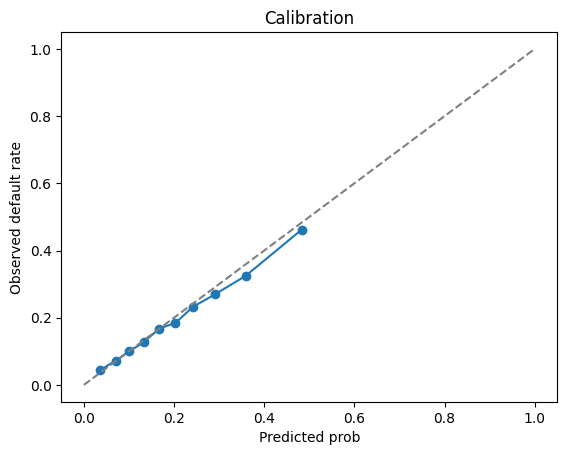

In [16]:
# get test probs + labels
model.eval()
ys, ps = [], []
with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(device)
        p = model(xb).cpu().numpy()
        ps.append(p)
        ys.append(yb.numpy())
ps = np.concatenate(ps)
ys = np.concatenate(ys)

# calibration plot (binned)
df_cal = pd.DataFrame({"y": ys, "p": ps})
df_cal['bin'] = pd.qcut(df_cal['p'], q=10, duplicates='drop')
cal = df_cal.groupby('bin').agg({'y':'mean','p':'mean'}).reset_index()
plt.plot(cal['p'], cal['y'], marker='o')
plt.plot([0,1],[0,1], '--', color='grey')
plt.xlabel('Predicted prob')
plt.ylabel('Observed default rate')
plt.title('Calibration')
plt.show()


In [17]:
# Load base arrays
X = np.load("data/processed/X_large.npy")  # states
y = np.load("data/processed/y_large.npy")  # 1 default, 0 fully paid
loan_amnt = np.load("data/processed/loan_amnt_large.npy")
int_rate = np.load("data/processed/int_rate_large.npy")  # percent as float

N = X.shape[0]
# For each state we create two transitions: (approve) and (deny)
states = np.repeat(X, 2, axis=0)   # shape (2N, D)
actions = np.tile(np.array([1.0, 0.0], dtype='float32'), N).reshape(-1,1)  # 1=approve, 0=deny
rewards = []
for i in range(N):
    y_i = int(y[i])
    loan = float(loan_amnt[i])
    ir = float(int_rate[i]) / 100.0
    # approve reward
    if y_i == 0:  # fully paid
        r_approve = loan * ir
    else:
        r_approve = -loan
    rewards.extend([r_approve, 0.0])
rewards = np.array(rewards, dtype='float32').reshape(-1,1)
# next_states: one-step episodes -> zeros or duplicate (we'll set zeros)
next_states = np.zeros_like(states)
# terminals: True (episode ends)
terminals = np.ones((states.shape[0], 1), dtype=bool)

print("States shape:", states.shape, "Actions shape:", actions.shape, "Rewards shape:", rewards.shape)


States shape: (538444, 84) Actions shape: (538444, 1) Rewards shape: (538444, 1)


In [22]:
import d3rlpy
print(d3rlpy.__version__)


2.8.1


In [28]:
import d3rlpy.algos as algos
print(dir(algos))


['AWAC', 'AWACConfig', 'BC', 'BCConfig', 'BCQ', 'BCQConfig', 'BEAR', 'BEARConfig', 'CQL', 'CQLConfig', 'CRR', 'CRRConfig', 'CalQL', 'CalQLConfig', 'ConstantEpsilonGreedy', 'DDPG', 'DDPGConfig', 'DQN', 'DQNConfig', 'DecisionTransformer', 'DecisionTransformerConfig', 'DiscreteBC', 'DiscreteBCConfig', 'DiscreteBCQ', 'DiscreteBCQConfig', 'DiscreteCQL', 'DiscreteCQLConfig', 'DiscreteDecisionTransformer', 'DiscreteDecisionTransformerConfig', 'DiscreteRandomPolicy', 'DiscreteRandomPolicyConfig', 'DiscreteSAC', 'DiscreteSACConfig', 'DoubleDQN', 'DoubleDQNConfig', 'Explorer', 'GreedyTransformerActionSampler', 'IQL', 'IQLConfig', 'IdentityTransformerActionSampler', 'LinearDecayEpsilonGreedy', 'NFQ', 'NFQConfig', 'NormalNoise', 'PLAS', 'PLASConfig', 'PLASWithPerturbation', 'PLASWithPerturbationConfig', 'PRDC', 'PRDCConfig', 'QLearningAlgoBase', 'QLearningAlgoImplBase', 'RandomPolicy', 'RandomPolicyConfig', 'ReBRAC', 'ReBRACConfig', 'SAC', 'SACConfig', 'SoftmaxTransformerActionSampler', 'StatefulT

In [29]:
print(dir(algos.CQL))
help(algos.CQL.__init__)


['__abstractmethods__', '__annotations__', '__class__', '__class_getitem__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__orig_bases__', '__parameters__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_abc_impl', 'action_scaler', 'action_size', 'batch_size', 'build_with_dataset', 'build_with_env', 'collect', 'compiled', 'config', 'copy_policy_from', 'copy_policy_optim_from', 'copy_q_function_from', 'copy_q_function_optim_from', 'create_impl', 'fit', 'fit_online', 'fitter', 'from_json', 'gamma', 'get_action_type', 'grad_step', 'impl', 'inner_create_impl', 'load_model', 'need_returns_to_go', 'observation_scaler', 'observation_shape', 'predict', 'predict_value', 'reset_optimizer_states', 'reward_scaler', 'sample_action', 'save', 'sav

In [36]:
from d3rlpy.dataset import MDPDataset
from d3rlpy.algos import DiscreteCQL, DiscreteCQLConfig

actions_int = actions.squeeze().astype("int64")

dataset = MDPDataset(
    states.astype("float32"),
    actions_int,
    rewards.squeeze().astype("float32"),
    terminals.squeeze().astype("bool")
)

# Minimal config with only batch_size
config = DiscreteCQLConfig(batch_size=256)

discrete_cql = DiscreteCQL(config=config, device="cpu", enable_ddp=False)

discrete_cql.fit(
    dataset,
    n_steps=20000
)

discrete_cql.save_model("models/discrete_cql_model.d3")
print("DiscreteCQL training finished and model saved!")


2025-12-12 08:33.24 [info     ] Signatures have been automatically determined. action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]) observation_signature=Signature(dtype=[dtype('float32')], shape=[(84,)]) reward_signature=Signature(dtype=[dtype('float32')], shape=[(1,)])
2025-12-12 08:33.24 [info     ] Action-space has been automatically determined. action_space=<ActionSpace.DISCRETE: 2>
2025-12-12 08:33.27 [info     ] Action size has been automatically determined. action_size=2
2025-12-12 08:33.28 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float32')], shape=[(84,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float32')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=2)
2025-12-12 08:33.28 [debug    ] Building models...            
2025-12-12 08:33.28 [debug    ] Models have been built.       
2025-12-12 08:33.28 [info  

Epoch 1/2:   0%|          | 0/10000 [00:00<?, ?it/s]

2025-12-12 08:36.48 [info     ] DiscreteCQL_20251212083328: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.006728504252433777, 'time_algorithm_update': 0.012895889139175415, 'loss': 2275.798078430176, 'td_loss': 2274.7789041137694, 'conservative_loss': 1.0191742498278618, 'time_step': 0.01986368670463562} step=10000
2025-12-12 08:36.48 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20251212083328/model_10000.d3


Epoch 2/2:   0%|          | 0/10000 [00:00<?, ?it/s]

2025-12-12 08:40.06 [info     ] DiscreteCQL_20251212083328: epoch=2 step=20000 epoch=2 metrics={'time_sample_batch': 0.006630123066902161, 'time_algorithm_update': 0.012777043652534485, 'loss': 2277.612386206055, 'td_loss': 2276.5797121948244, 'conservative_loss': 1.032672333598137, 'time_step': 0.01963563070297241} step=20000
2025-12-12 08:40.06 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20251212083328/model_20000.d3
DiscreteCQL training finished and model saved!


In [39]:
import numpy as np
from sklearn.model_selection import train_test_split
from d3rlpy.dataset import MDPDataset
from d3rlpy.algos import DiscreteCQL, DiscreteCQLConfig

# Assume your full dataset arrays: X, y, loan_amnt, int_rate
# X: features (numpy array)
# y: actions/labels (0 or 1)
# loan_amnt, int_rate: numpy arrays aligned with X

RANDOM_SEED = 42

# Step 1: Split dataset (train/val/test)
idx_train, idx_temp = train_test_split(np.arange(len(X)), test_size=0.3, stratify=y, random_state=RANDOM_SEED)
idx_val, idx_test = train_test_split(idx_temp, test_size=0.5, stratify=y[idx_temp], random_state=RANDOM_SEED)

# Step 2: Prepare dataset for training
actions_int_train = y[idx_train].astype("int64")

# Terminals array: mark last step as terminal to satisfy MDPDataset requirement
terminals = np.zeros(len(idx_train), dtype=bool)
terminals[-1] = True  # minimal episode termination

dataset = MDPDataset(
    observations=X[idx_train].astype("float32"),
    actions=actions_int_train,
    rewards=y[idx_train].astype("float32"),  # or your custom reward array if different
    terminals=terminals
)

# Step 3: Setup and create DiscreteCQL agent
config = DiscreteCQLConfig(batch_size=256)
discrete_cql = DiscreteCQL(config=config, device="cpu", enable_ddp=False)

# Step 4: Train the agent
discrete_cql.fit(dataset, n_steps=20000)

# Step 5: Predict on test states
X_test_states = X[idx_test].astype('float32')
actions_rl = discrete_cql.predict(X_test_states).ravel()

# DiscreteCQL returns discrete actions, but if unsure:
actions_rl_bin = (actions_rl >= 0.5).astype(int)

# Step 6: Prepare evaluation arrays
loan_test = loan_amnt[idx_test]
ir_test = int_rate[idx_test]
y_test_true = y[idx_test]

# Step 7: Compute EPV function
def compute_epv(actions_bin, loan_arr, ir_arr, y_true):
    r_list = []
    for a, loan_i, ir_i, y_i in zip(actions_bin, loan_arr, ir_arr, y_true):
        if a == 0:
            r = 0.0
        else:
            if y_i == 0:
                r = loan_i * (ir_i / 100.0)
            else:
                r = -loan_i
        r_list.append(r)
    mean_epv = np.mean(r_list)
    total_epv = np.sum(r_list)
    mean_pos_epv = np.mean([x for x in r_list if x > 0]) if any(x > 0 for x in r_list) else 0.0
    return mean_epv, total_epv, mean_pos_epv

# Step 8: Evaluate policy EPV
epv_mean, epv_total, epv_pos = compute_epv(actions_rl_bin, loan_test, ir_test, y_test_true)

print("RL policy EPV (mean per applicant):", epv_mean)
print("RL policy EPV (total):", epv_total)
print("RL policy EPV (mean positive reward):", epv_pos)

# Step 9: Save model (optional)
discrete_cql.save_model("models/discrete_cql_model.d3")


2025-12-12 08:42.39 [info     ] Signatures have been automatically determined. action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]) observation_signature=Signature(dtype=[dtype('float32')], shape=[(84,)]) reward_signature=Signature(dtype=[dtype('float32')], shape=[(1,)])
2025-12-12 08:42.39 [info     ] Action-space has been automatically determined. action_space=<ActionSpace.DISCRETE: 2>
2025-12-12 08:42.39 [info     ] Action size has been automatically determined. action_size=2
2025-12-12 08:42.39 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float32')], shape=[(84,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float32')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=2)
2025-12-12 08:42.39 [debug    ] Building models...            
2025-12-12 08:42.39 [debug    ] Models have been built.       
2025-12-12 08:42.39 [info  

Epoch 1/2:   0%|          | 0/10000 [00:00<?, ?it/s]

2025-12-12 08:45.46 [info     ] DiscreteCQL_20251212084239: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.005069274139404297, 'time_algorithm_update': 0.013192485284805298, 'loss': 0.6526093394517899, 'td_loss': 0.14229694746136665, 'conservative_loss': 0.5103123922735453, 'time_step': 0.01850544753074646} step=10000
2025-12-12 08:45.46 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20251212084239/model_10000.d3


Epoch 2/2:   0%|          | 0/10000 [00:00<?, ?it/s]

2025-12-12 08:48.46 [info     ] DiscreteCQL_20251212084239: epoch=2 step=20000 epoch=2 metrics={'time_sample_batch': 0.004897323250770569, 'time_algorithm_update': 0.012752530670166016, 'loss': 0.6545941716969014, 'td_loss': 0.15166811566874386, 'conservative_loss': 0.5029260560274124, 'time_step': 0.01787464084625244} step=20000
2025-12-12 08:48.46 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20251212084239/model_20000.d3
RL policy EPV (mean per applicant): -1043.2080164303304
RL policy EPV (total): -42128912.53552246
RL policy EPV (mean positive reward): 3443.357


In [40]:
# get classifier predicted probs for same test indices
model.eval()
with torch.no_grad():
    X_test_tensor = torch.from_numpy(X[idx_test]).float().to(device)
    probs = model(X_test_tensor).cpu().numpy().ravel()

# Sweep thresholds
thresholds = np.linspace(0.01, 0.99, 99)
best_t = None
best_epv = -1e12
results = []
for T in thresholds:
    actions_dl = (probs < T).astype(int)  # approve if predicted default prob < T
    epv_mean_t, epv_total_t, _ = compute_epv(actions_dl, loan_test, ir_test, y_test_true)
    results.append((T, epv_mean_t))
    if epv_mean_t > best_epv:
        best_epv = epv_mean_t
        best_t = T

print("Best DL threshold by EPV:", best_t, "EPV:", best_epv)

# Compare with RL EPV
print("RL EPV mean:", epv_mean, "DL best EPV:", best_epv)


Best DL threshold by EPV: 0.09 EPV: 40.72902895654249
RL EPV mean: -1043.2080164303304 DL best EPV: 40.72902895654249


In [43]:
import numpy as np
import torch

# --- Assume these are defined earlier ---
# X: features numpy array
# y: true labels (0/1)
# loan_amnt: loan amount numpy array
# int_rate: interest rate numpy array
# idx_test: indices for test split
# discrete_cql: trained RL agent (DiscreteCQL)
# model: your DL PyTorch model
# device: torch device (e.g. "cpu" or "cuda")
# best_t: threshold value for DL probabilities

# Step 1: Get RL actions on test set
actions_rl_test = discrete_cql.predict(X[idx_test].astype('float32')).ravel()
actions_rl_bin_test = (actions_rl_test >= 0.5).astype(int)

# Step 2: Get DL model predicted probabilities and threshold to get actions
with torch.no_grad():
    inputs = torch.from_numpy(X[idx_test]).float().to(device)
    probs_all = model(inputs).cpu().numpy().ravel()

actions_dl_best = (probs_all < best_t).astype(int)

# Step 3: Find disagreement indices between RL and DL actions
disagree_idx = np.where(actions_dl_best != actions_rl_bin_test)[0]
print("Disagreements count:", len(disagree_idx))

# Step 4: Print first 10 disagreement examples with relevant info
for i in disagree_idx[:10]:
    ii = idx_test[i]  # original data index
    print(f"Index: {ii}, loan_amnt: {loan_amnt[ii]}, int_rate: {int_rate[ii]}, y_true: {y[ii]}, "
          f"dl_prob: {probs_all[i]:.4f}, dl_action: {actions_dl_best[i]}, rl_action: {actions_rl_bin_test[i]}")


Disagreements count: 17196
Index: 6705, loan_amnt: 7500.0, int_rate: 9.989999771118164, y_true: 0, dl_prob: 0.0810, dl_action: 1, rl_action: 0
Index: 155897, loan_amnt: 12000.0, int_rate: 21.18000030517578, y_true: 0, dl_prob: 0.3639, dl_action: 0, rl_action: 1
Index: 220759, loan_amnt: 35000.0, int_rate: 25.799999237060547, y_true: 0, dl_prob: 0.4504, dl_action: 0, rl_action: 1
Index: 47297, loan_amnt: 18325.0, int_rate: 23.989999771118164, y_true: 1, dl_prob: 0.4854, dl_action: 0, rl_action: 1
Index: 34095, loan_amnt: 19300.0, int_rate: 14.649999618530273, y_true: 1, dl_prob: 0.2928, dl_action: 0, rl_action: 1
Index: 124221, loan_amnt: 21500.0, int_rate: 14.460000038146973, y_true: 0, dl_prob: 0.3095, dl_action: 0, rl_action: 1
Index: 201893, loan_amnt: 8625.0, int_rate: 23.989999771118164, y_true: 1, dl_prob: 0.3101, dl_action: 0, rl_action: 1
Index: 151519, loan_amnt: 21000.0, int_rate: 18.920000076293945, y_true: 0, dl_prob: 0.3126, dl_action: 0, rl_action: 1
Index: 12684, loan_am

In [44]:
# Save preprocessor used for final processed data
joblib.dump(preprocessor, "models/preprocessor_final.joblib")
# Save supervised model (state_dict saved earlier)
torch.save(model.state_dict(), "models/mlp_final.pt")
# d3rlpy saved model earlier
print("Saved models to models/ directory. Save predictions and summary.")
# Save evaluation table
pd.DataFrame({"thresh":[best_t], "dl_epv":[best_epv], "rl_epv":[epv_mean]}).to_csv("models/summary_results.csv", index=False)


Saved models to models/ directory. Save predictions and summary.
